## Setup

In [18]:
from environment import CollisionChecker, construct_benchmark_environments
from planners.IPBasicPRM import BasicPRM
from optimize_path import OptimizeFlyby
import pprint
import networkx as nx
import numpy as np

## Load Environments

In [19]:
env_dict = construct_benchmark_environments()

## Create Planner and Collision Checker for each environment

In [20]:
for name, item in env_dict.items():
    cc = CollisionChecker(item["env"])
    planner = BasicPRM(cc)
    # Inject Graph
    G = nx.Graph()

    node_names = []

    for i, coord in enumerate(item["smooth_path"]):
        # Determine the name based on position in the list
        if i == 0:
            n = "start"
        elif i == len(item["smooth_path"]) - 1:
            n = "goal"
        else:
            n = f"{i}" # Naming middle nodes generically
        
        node_names.append(n)
        
        # Add node with the 'pos' attribute
        G.add_node(n, pos=coord)

    # Add edges connecting each node to the next
    for i in range(len(node_names) - 1):
        current_node = node_names[i]
        next_node = node_names[i+1]
        G.add_edge(current_node, next_node)

    planner.graph = G
    
    env_dict[name]["planner"] = planner



## Show the Environments

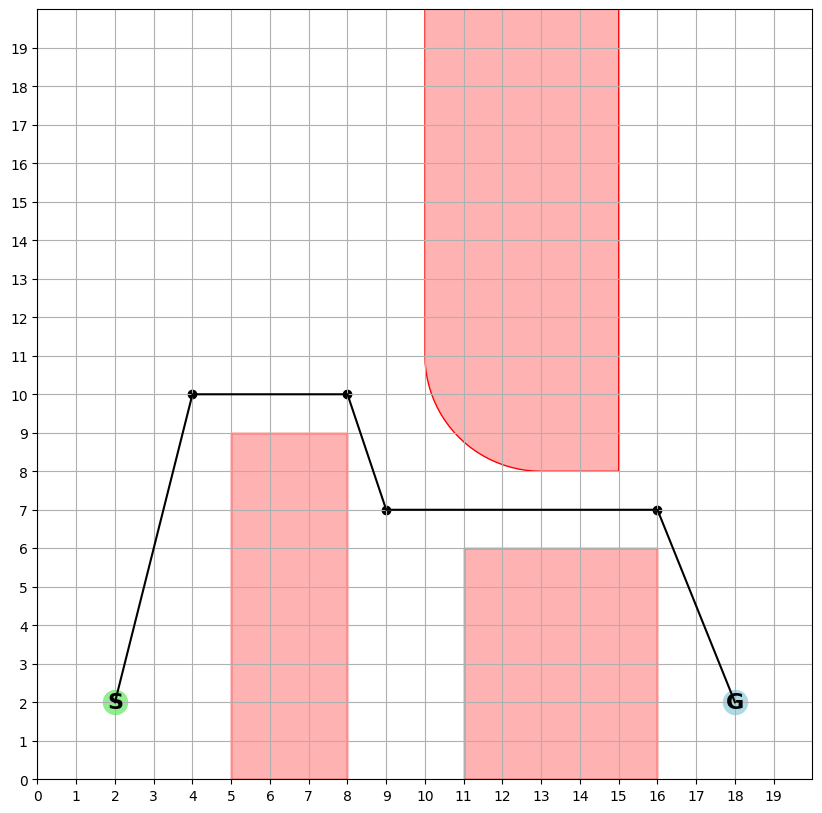

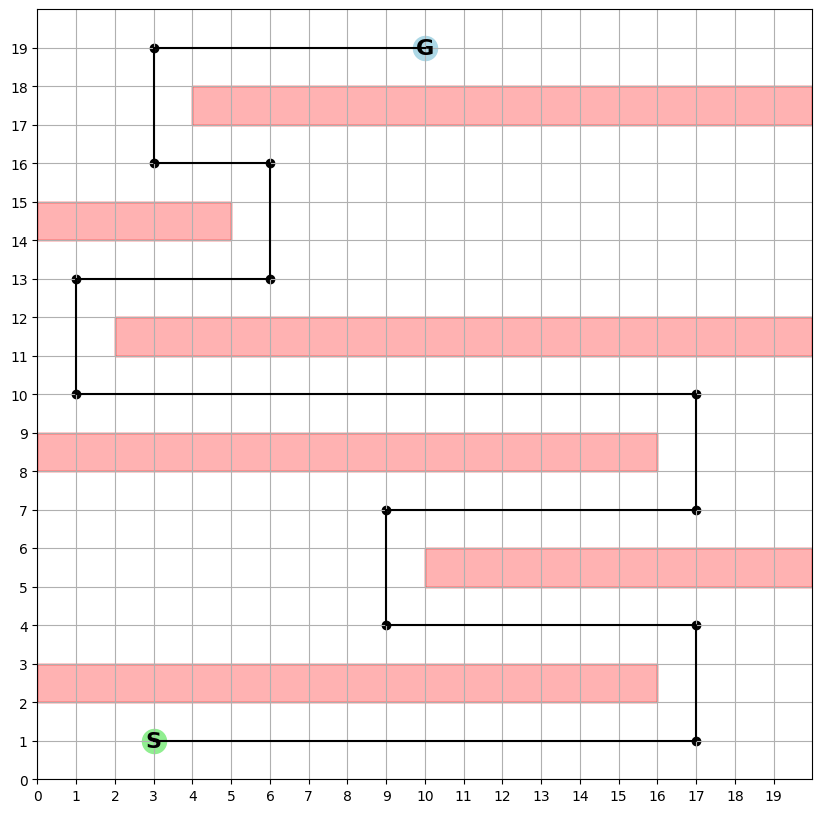

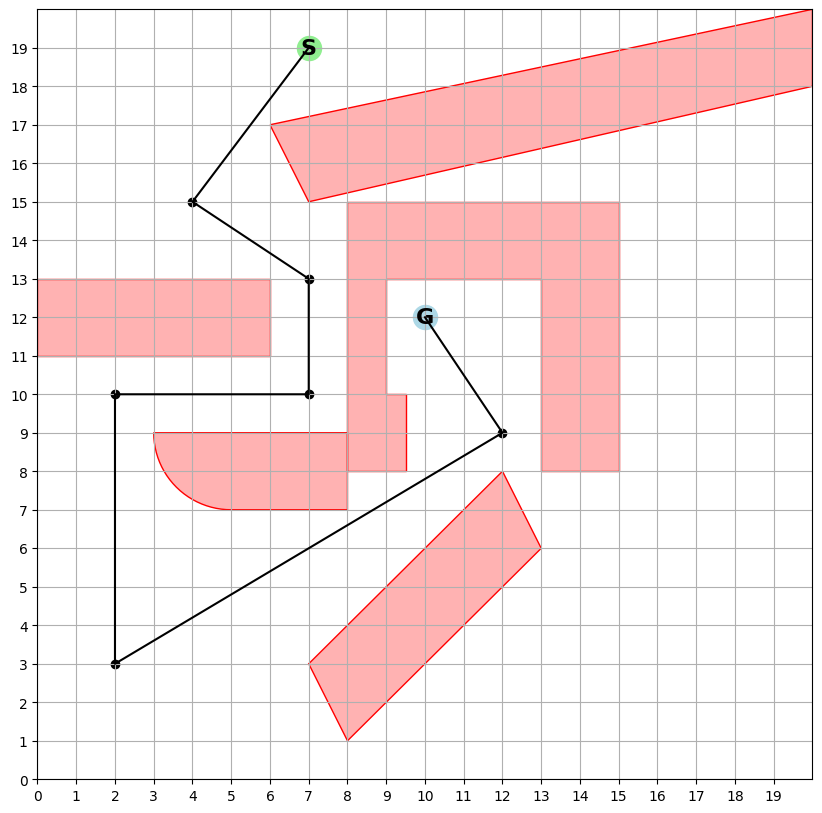

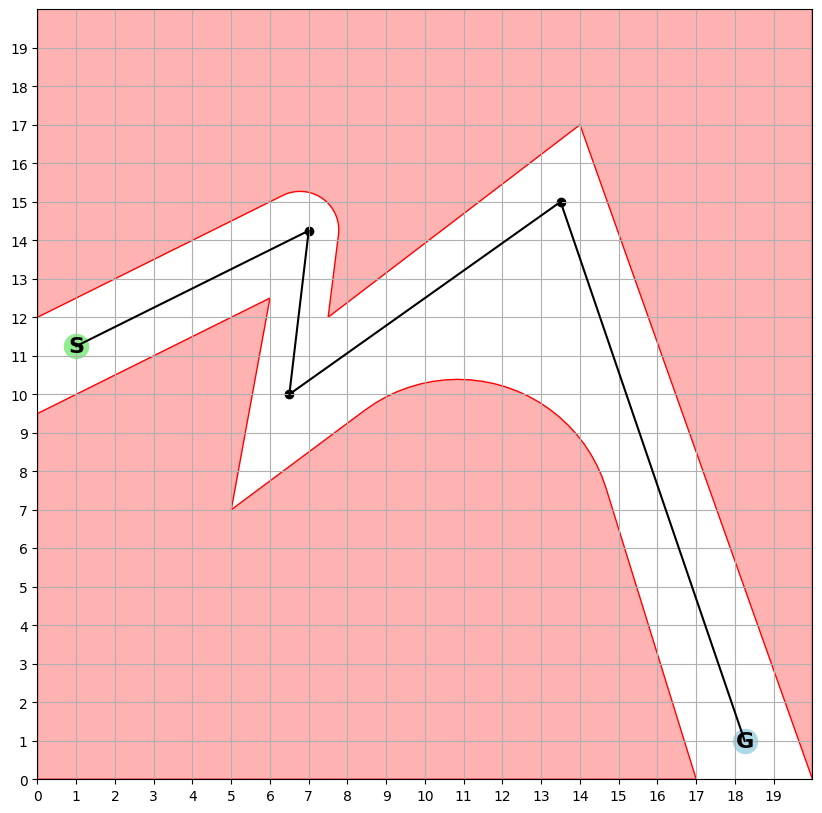

In [21]:
for name, item in env_dict.items():
    ax = item["planner"]._collisionChecker.draw_enviroments()
    item["planner"]._collisionChecker.draw_path(item["smooth_path"], ax=ax)


In [22]:
pprint.pprint(env_dict)

#print(env_dict.items)

{'1': {'env': {'obs_1': <POLYGON ((5 0, 8 0, 8 9, 5 9, 5 0))>,
               'obs_2': <POLYGON ((11 0, 16 0, 16 6, 11 6, 11 0))>,
               'obs_3': <POLYGON ((10 11, 10.006 10.804, 10.026 10.608, 10.058 10.415, 10.102 10.224...>},
       'planner': <planners.IPBasicPRM.BasicPRM object at 0x7ee8767de850>,
       'smooth_path': [(2.0, 2.0),
                       (4.0, 10.0),
                       (8.0, 10.0),
                       (9.0, 7.0),
                       (16.0, 7.0),
                       (18.0, 2.0)]},
 '2': {'env': {'obs_1': <POLYGON ((0 2, 16 2, 16 3, 0 3, 0 2))>,
               'obs_2': <POLYGON ((10 5, 20 5, 20 6, 10 6, 10 5))>,
               'obs_3': <POLYGON ((0 8, 16 8, 16 9, 0 9, 0 8))>,
               'obs_4': <POLYGON ((2 11, 20 11, 20 12, 2 12, 2 11))>,
               'obs_5': <POLYGON ((0 14, 5 14, 5 15, 0 15, 0 14))>,
               'obs_6': <POLYGON ((4 17, 20 17, 20 18, 4 18, 4 17))>},
       'planner': <planners.IPBasicPRM.BasicPRM object at 0x7ee8

### 2. Aufgabe

#### Optimierung der ersten Aufgabe: Lösungspfad = Liste mtit Namen der Punkte dieses Pfades

In [23]:
data = env_dict["2"]
planner = data["planner"]
coords_path = data["smooth_path"]
node_names_path = []

for i, pos in enumerate(coords_path):
    node_name = f"P1_{i}"
    
    planner.graph.add_node(node_name, pos=pos)
    
    node_names_path.append(node_name)

In [24]:
optimizer = OptimizeFlyby()
my_config = {'r_init': 0.49}


result = optimizer.optimizePath_combinedmodel(node_names_path, planner, my_config)

print(result)

[('P1_0', 0.0, 'none'), ('P1_1', 0.49, 'cutting'), ('P1_2', 0.49, 'flyby'), ('P1_3', 0.49, 'cutting'), ('P1_4', 0.49, 'flyby'), ('P1_5', 0.49, 'cutting'), ('P1_6', 0.49, 'flyby'), ('P1_7', 0.49, 'cutting'), ('P1_8', 0.49, 'flyby'), ('P1_9', 0.49, 'flyby'), ('P1_10', 0.49, 'flyby'), ('P1_11', 0.49, 'flyby'), ('P1_12', 0.49, 'flyby'), ('P1_13', 0.0, 'none')]


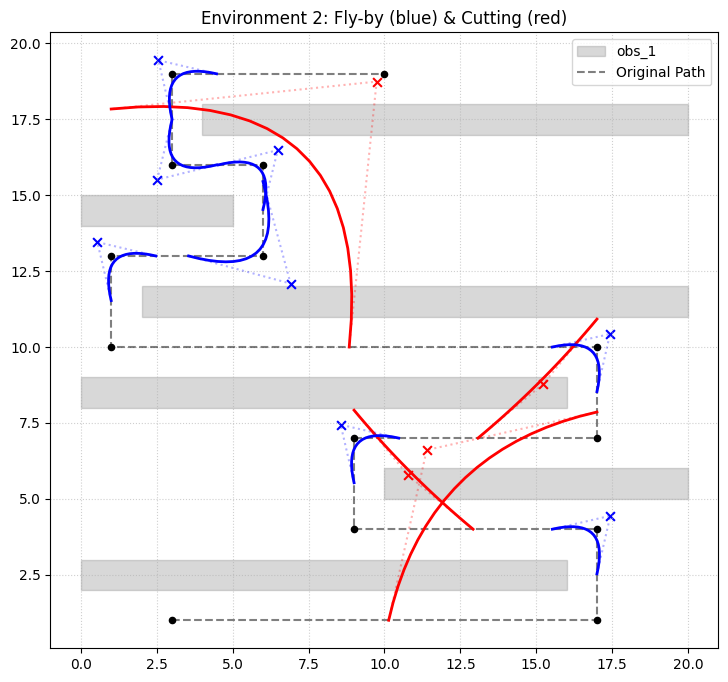

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as MatplotPolygon

def visualize_results(env_id, results, env_dict):
    data = env_dict[str(env_id)]
    obs_dict = data['env']
    original_path = np.array(data['smooth_path'])
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # 1. Hindernisse zeichnen
    for obs_name, poly in obs_dict.items():
        x, y = poly.exterior.xy
        ax.add_patch(MatplotPolygon(np.column_stack((x, y)), color='gray', alpha=0.3, label=obs_name if '1' in obs_name else ""))

    # 2. Originalen Pfad zeichnen (gestrichelt)
    ax.plot(original_path[:, 0], original_path[:, 1], 'k--', alpha=0.5, label='Original Path')
    ax.scatter(original_path[:, 0], original_path[:, 1], c='black', s=20, zorder=5)

    # 3. Optimierten Pfad mit Parabeln berechnen und zeichnen
    new_path_points = []
    
    # Wir iterieren durch die Ergebnisse (ohne Start und Ende für die Kurven)
    for i in range(1, len(original_path) - 1):
        p1 = original_path[i-1]
        p2 = original_path[i]
        p3 = original_path[i+1]
        
        node_name, r, mode = results[i]
        
        if r > 0:
            # Mathematik nach Hein (Folie 101)
            dist12 = np.linalg.norm(p1 - p2)
            dist23 = np.linalg.norm(p3 - p2)
            k = dist12 / dist23 if dist23 != 0 else 1.0
            
            # P2n Fly-by berechnen
            nenner = 1.0 - 0.25 * r * (1.0 + k)
            zaehler = p2 - 0.25 * r * (p1 + k * p3)
            p2n_flyby = zaehler / nenner
            
            # Punkt-Modus festlegen
            if mode == "flyby":
                p2n = p2n_flyby
                color = 'blue'
            else: # cutting
                p2n = p2 - (p2n_flyby - p2) # Nach innen spiegeln
                color = 'red'
            
            # Start- und Endpunkt der Kurve auf den Segmenten
            S = p2 + r * (p1 - p2)
            E = p2 + (r * k) * (p3 - p2)
            
            # Parabel diskretisieren (Quadratic Bezier)
            t_vals = np.linspace(0, 1, 20)
            parabola = np.array([(1-t)**2 * S + 2*(1-t)*t * p2n + t**2 * E for t in t_vals])
            
            # Kurve plotten
            ax.plot(parabola[:, 0], parabola[:, 1], color=color, linewidth=2)
            # Hilfslinien zum virtuellen Punkt P2n (optional zur Kontrolle)
            ax.plot([S[0], p2n[0], E[0]], [S[1], p2n[1], E[1]], color=color, linestyle=':', alpha=0.3)
            ax.scatter(p2n[0], p2n[1], color=color, marker='x', s=40)

    ax.set_title(f"Environment {env_id}: Fly-by (blue) & Cutting (red)")
    ax.legend()
    ax.set_aspect('equal')
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.show()

# Beispielaufruf für Environment '1'
visualize_results('2', result, env_dict)